2022-05-30 04:39:40.721673: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2022-05-30 04:39:40.721727: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: spk
2022-05-30 04:39:40.721737: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: spk
2022-05-30 04:39:40.721884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-05-30 04:39:40.721917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-05-30 04:39:40.721926: E tensorflow/stream_executor/cuda/cuda_diagnostics.cc:313] kernel version 470.103.1 does not match DSO version 470.129.6 -- cannot find working devices in this configuration
2022-05-30 04:39:40.722224: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binar

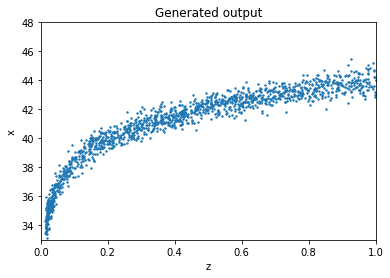

tf.Tensor([[-936.4295   748.5984   456.03687]], shape=(1, 3), dtype=float32)
Class : tf.Tensor([1], shape=(1,), dtype=int64)
Press enter to continue...


''

In [2]:
import os
import sys
from shutil import copyfile
import json
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping

# add parent directory of project to system path, to access all the packages in project, sys.path.append appends are not permanent
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath('train.py')))))))

from src.model.SGAN.Generator import Generator
from src.model.SGAN.Discriminator import Discriminator
from src.model.SGAN.UnsupervisedDiscriminator import UnsupervisedDiscriminator
from src.model.SGAN.SupervisedDiscriminator import SupervisedDiscriminator
from src.model.SGAN.SGAN import SGAN
from src.model.SGAN.dark_energy.GANMonitor import GANMonitor

readlines = ""
with open('Params.json') as file:
    readlines = file.read() 

Params = json.loads(readlines) 
latent_dim = Params['latent_dim'] 
epochs = Params['epochs']
patience = Params['patience']
lr_gen = Params['lr_gen']
beta_1_gen = Params['beta_1_gen']
lr_disc = Params['lr_disc']
beta_1_disc= Params['beta_1_disc']
batch_size = Params['batch_size']
input_dim = Params['input_dim']
output_dim = Params['output_dim']
n_classes = Params['n_classes']
train_size = Params['train_size']
buffer_size = train_size 
outdir = Params['outdir'] 

if not os.path.isdir(outdir):
    os.makedirs(outdir)
if not os.path.isdir(os.path.join(outdir, 'fig')):
    os.mkdir(os.path.join(outdir, 'fig')) 
if not os.path.isdir(os.path.join(outdir, 'ckpt')):
    os.mkdir(os.path.join(outdir, 'ckpt'))
if not os.path.isdir(os.path.join(outdir, 'log')):
    os.mkdir(os.path.join(outdir, 'log'))

copyfile('Params.json',os.path.join(outdir, 'Params.json'))

z = np.genfromtxt('../../../data/dark_energy_models/z.csv', dtype=np.float32)
x_real = np.genfromtxt('../../../data/dark_energy_models/x_real.csv', dtype=np.float32)

# normalize the y data, very important for GAN training
scaler = StandardScaler()
scaler.fit(x_real[0].reshape(1,-1))
x_real = scaler.transform(x_real)

generator = Generator(latent_dim)
discriminator = Discriminator(output_dim)
sup_discriminator = SupervisedDiscriminator(n_classes, discriminator)
unsup_discriminator = UnsupervisedDiscriminator(discriminator)

sgan = SGAN(latent_dim, generator, sup_discriminator, unsup_discriminator, z, scaler)
sgan.compile(
    tf.keras.optimizers.Adam(learning_rate=lr_gen, beta_1=beta_1_gen),
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc), 
    tf.keras.optimizers.Adam(learning_rate=lr_disc, beta_1=beta_1_disc),
    tf.keras.losses.BinaryCrossentropy(from_logits=True),
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)

sgan_checkpoint_path = os.path.join(outdir,"ckpt/sgan.ckpt")
g_checkpoint_path = os.path.join(outdir,"ckpt/generator.ckpt")
d_checkpoint_path = os.path.join(outdir,"ckpt/discriminator.ckpt")

# load the best model
sgan.load_weights(sgan_checkpoint_path)

x = sgan.generator(tf.random.normal((1,latent_dim)))
x = scaler.inverse_transform(x)

plt.figure()
plt.scatter(z, np.reshape(x, (output_dim) ), s=2)
plt.title('Generated output')
plt.xlabel('z')
plt.ylabel('x')
plt.xlim(0,1)
plt.ylim(33,48.)
plt.savefig(os.path.join(outdir, 'fig/sample_out.png'))
plt.draw()
plt.pause(0.001)
plt.show()

# get the class label assigned
print(sgan.s_discriminator(x))
print('Class :', tf.argmax(sgan.s_discriminator(x), axis=-1))

input('Press enter to continue...')